# 利用自编码器生成MNIST手写数字

# 1.自编码器简介

## 1.1 什么是自编码器

自编码器属于生成模型，是一种数据的压缩算法，其中数据的压缩和解压缩函数都是从样本中自动学习的。在大部分用到自编码器的场合，压缩和解压缩函数是通过神经网络实现的。<br>
+ 自编码器是数据相关的，意味着自编码器只能压缩与训练数据类似的数据，例如使用人脸训练出来的自编码器再去压缩别的图片，比如树的图片时，性能就很差，因为它学习到的特征是与人脸相关的<br>
+ 自编码器是有损的，是指解压缩的输出与原来的输入相比是退化的，这与无损压缩算法不同<br>
+ 自编码器是一个自监督学习算法，并不是一个无监督算法，其标签产生自输入数据

## 1.2 自编码器的结构

自编码器包含编码器（Encoder）与解码器（Decoder）<br>
+ 编码器能将输入压缩成潜在空间表征<br>
+ 解码器能重构来自潜在空间表征的输入<br>

如下图所示：输入的图片通过编码器压缩与解码器重构，得到了一个包含原始输入大部分特征的新图片。**自编码器可以像主成分分析（PCA）一样，给特征属性进行降维。**

![png](https://github.com/shiyadong123/Myimage/blob/master/AE01.jpg?raw=true)

## 1.3 自编码器的模拟过程

如下图所示，首先对输入进行编码，经过激活函数后，再用进行解码，从而使得最终的目标值等于输入值。<br>

通俗来讲，该过程可以看作是对输入数据的压缩编码，将高维的原始数据用低维的向量表示，使压缩后的低维向量能保留输入数据的典型特征，从而能够较为方便的恢复原始数据。

![png](http://imgcdn.atyun.com/2018/03/Screen-Shot-2018-03-07-at-8.24.37-AM.png)

# 2.利用Pytorch搭建自编码器

## 2.1 数据预处理

+ 导入必要的库

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

+ 设定超参数

In [2]:
# 超参数
EPOCH = 15     # 迭代轮数
BATCH_SIZE = 100  # batch大小
LR = 0.005         # 学习率

+ MNIST数据集的加载与展示

In [3]:
# 加载训练集数据
train_data = torchvision.datasets.MNIST(
    root='MNIST_data/',
    train=True,                                     
    transform=torchvision.transforms.ToTensor(),     
                                                    
    download=False,                       
)


train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

训练集维度： torch.Size([60000, 28, 28])
训练集数量： torch.Size([60000])


([], <a list of 0 Text yticklabel objects>)

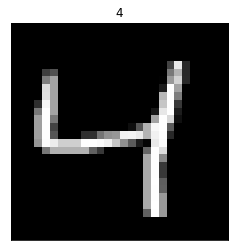

In [4]:
# 输出训练集维度
print("训练集维度：", train_data.data.size())     
print("训练集数量：", train_data.targets.size())

# 图片展示
plt.imshow(train_data.data[2].numpy(), cmap='gray')
plt.title('%i' % train_data.targets[2])

# 去掉坐标轴
plt.xticks(())
plt.yticks(())

## 2.2 搭建模型

搭建一个自动编码器需要完成下面三样工作：

+ 搭建编码器
+ 搭建解码器
+ 设定一个损失函数，用于衡量由于压缩而损失掉的信息

编码器和解码器的参数可以通过最小化损失函数进行优化，例如SGD或者Adam。<br>

如下图所示，自编码器包含编码器与解码器，其中激活函数为`tanh`函数，最终目标是得到的输出结果能够尽量与输入相似。

![png](https://github.com/shiyadong123/Myimage/blob/master/AE05.png?raw=true)

 + 定义`encoder`与`decoder`

In [5]:
# 定义网络结构
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # 编码器
        self.encoder = nn.Sequential(
            # 输入数据28×28，拉直变为784，第一个全连接层128个神经元
            nn.Linear(28*28, 128),  
            nn.Tanh(),  # 非线性输出
            
            # 第二个全连接层64个神经元
            nn.Linear(128, 64),
            nn.Tanh(),
            
            # 第三个全连接层12个神经元
            nn.Linear(64, 12),
            nn.Tanh(),
            
            # 第四个全连接层3个神经元
            nn.Linear(12, 3),       # 编码器将输入压缩成3个特征
        )
        
        # 解码器
        self.decoder = nn.Sequential(
            
            # 输入数据维度为3，第一个全连接层12个神经元
            nn.Linear(3, 12),      # 可以考虑使用卷积层
            nn.Tanh(),
            
            # 第二个全连接层64个神经元
            nn.Linear(12, 64),
            nn.Tanh(),
            
            # 第三个全连接层128个神经元
            nn.Linear(64, 128),
            nn.Tanh(),
            
            nn.Linear(128, 28*28),  # 解码器将压缩特征进行重构
            nn.Sigmoid(),           
        )
        
        # 定义前向传播       
    def forward(self, x):
    
        # 编码器的前向传播
        encoded = self.encoder(x)
    
        # 解码器接受编码器的输出，进行前向传播
        decoded = self.decoder(encoded)
    
        return encoded, decoded

In [6]:
# 实例化
autoencoder = AutoEncoder()

# 输出自编码器的结构
print(autoencoder)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): Tanh()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): Tanh()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


+ 定义损失函数为均方误差

In [7]:
# 利用adam进行优化更新
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
# 定义损失函数
loss_func = nn.MSELoss()

## 2.3 模型的训练与输出

Epoch:  1 | train loss: 0.0494


D:\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


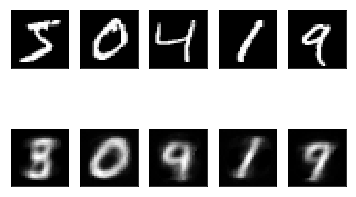

Epoch:  2 | train loss: 0.0391


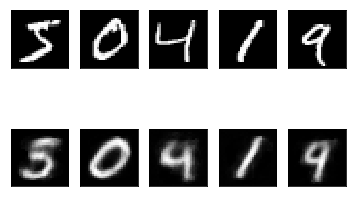

Epoch:  3 | train loss: 0.0401


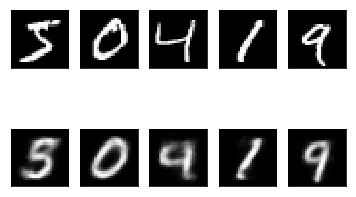

Epoch:  4 | train loss: 0.0370


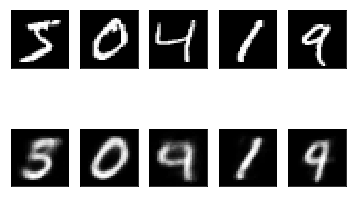

Epoch:  5 | train loss: 0.0350


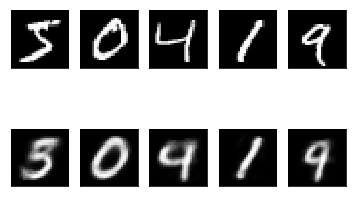

Epoch:  6 | train loss: 0.0373


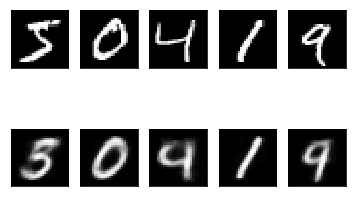

Epoch:  7 | train loss: 0.0335


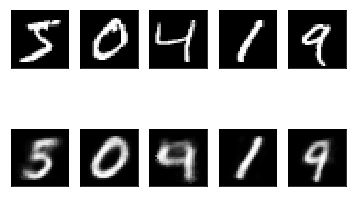

Epoch:  8 | train loss: 0.0358


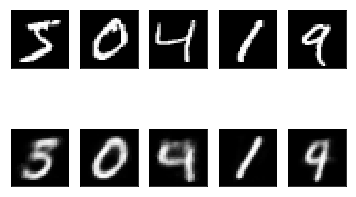

Epoch:  9 | train loss: 0.0368


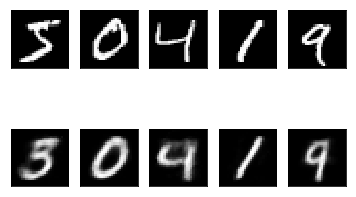

Epoch:  10 | train loss: 0.0319


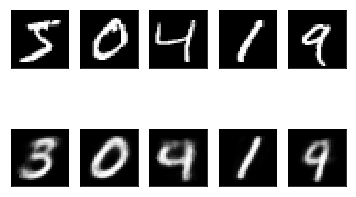

Epoch:  11 | train loss: 0.0379


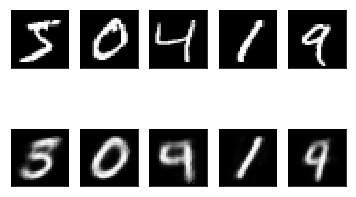

Epoch:  12 | train loss: 0.0363


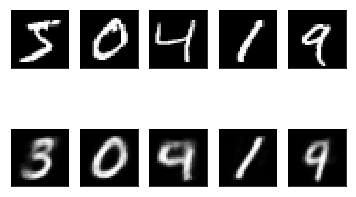

Epoch:  13 | train loss: 0.0355


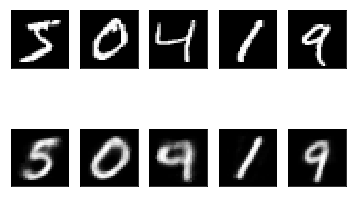

Epoch:  14 | train loss: 0.0318


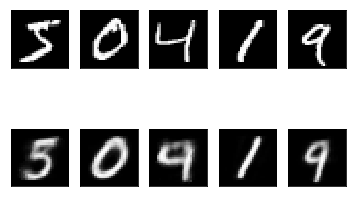

Epoch:  15 | train loss: 0.0325


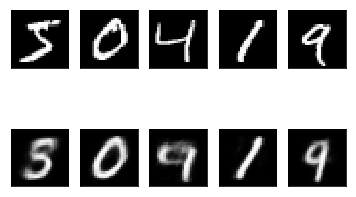

In [8]:
# 进行训练
for epoch in range(EPOCH):
    
    for step, (x, b_label) in enumerate(train_loader):
        b_x = x.view(-1, 28*28)   # batch x, shape (batch, 28*28)
        b_y = x.view(-1, 28*28)   # batch y, shape (batch, 28*28)

        encoded, decoded = autoencoder(b_x)

        loss = loss_func(decoded, b_y)      # 损失函数
        optimizer.zero_grad()               # 梯度初始化
        loss.backward()                     # 梯度反向传播
        optimizer.step()                    # 更新梯度


            
    # 输出一个损失值
    print('Epoch: ', epoch + 1, '| train loss: %.4f' % loss.data.numpy())
    
    # 查看原始数据（打印5个）--> 第一行
    f, a = plt.subplots(2, 5)

    view_data = train_data.train_data[:5].view(-1, 28*28).type(torch.FloatTensor)/255.

    # 输出成图片形式
    for i in range(5):
        a[0, i].imshow(view_data.numpy()[i].reshape(28, 28), cmap='gray')
        a[0, i].set_xticks(())
        a[0, i].set_yticks(())

    # 绘制解码输出的图片 --> 第二行，与第一行进行对比
    _, decoded_data = autoencoder(view_data)
            
    # 输出成图片形式
    for i in range(5):
        a[1, i].imshow(decoded_data.detach().numpy()[i].reshape(28, 28), cmap='gray')
        a[1, i].set_xticks(())
        a[1, i].set_yticks(())
#         plt.draw()
#         plt.pause(0.05)
    plt.show()

在整个训练模拟过程中，我们发现自编码器生成的图片可以得到一个跟输出很类似的结果，损失值也是在不断变小。在解码过程中，对于“0”，“1”，“9”的生成过程比较顺利，我们可以比较清晰的辨别出最终图片与原始输入相差无几；但是对于“4”，“5”的生成过程，“5”在解码过程中一度比较像“3”，“4”一度比较像“9”，这也是由于手写数字并不工整导致的。

# 3. 总结

本案例讲解了自编码器模型在生成手写数字图片上的应用，首先介绍了自编码器模型的基本原理与结构，其中包括编码器和解码器。然后利用Pytorch深度学习框架搭建自编码器模型，训练模型最终得到手写数字的生成图片，经过与原始输入进行比对，效果良好。在定义编码器（encoder）与解码器（decoder）过程中，本案例使用了全连接神经网络，为了使得生成的结果更好，感兴趣的同学可以尝试使用卷积神经网络，在此不再赘述。